<a href="https://colab.research.google.com/github/yesiltepe-hidir/NVAE/blob/master/Deterministic_Reconstructions_LSUN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!git clone https://github.com/yesiltepe-hidir/NVAE.git
!pip install tensorboardX

Cloning into 'NVAE'...
remote: Enumerating objects: 118, done.
remote: Counting objects: 100% (48/48), done.
remote: Compressing objects: 100% (43/43), done.
remote: Total 118 (delta 25), reused 10 (delta 5), pack-reused 70
Receiving objects: 100% (118/118), 8.74 MiB | 5.89 MiB/s, done.
Resolving deltas: 100% (50/50), done.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 125 kB 30.2 MB/s 


In [2]:
%cd NVAE 

/content/NVAE


In [3]:
!rm -rf church_outdoor_train_lmdb.zip church_outdoor_val_lmdab.zip church_outdoor_train_lmdb

# LSUN Church Dataset
!git clone https://github.com/fyu/lsun.git
!python3 lsun/download.py -c church_outdoor

# Unzip 
!unzip church_outdoor_train_lmdb.zip
!unzip church_outdoor_val_lmdb.zip

# Remove
!rm -rf lsun
!rm -rf church_outdoor_train_lmdb.zip
!rm -rf church_outdoor_val_lmdb.zip

Cloning into 'lsun'...
remote: Enumerating objects: 76, done.
remote: Counting objects: 100% (1/1), done.
remote: Total 76 (delta 0), reused 0 (delta 0), pack-reused 75
Unpacking objects: 100% (76/76), done.
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 2335M  100 2335M    0     0  7055k      0  0:05:38  0:05:38 --:--:-- 5198k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 5817k  100 5817k    0     0  2796k      0  0:00:02  0:00:02 --:--:-- 2796k
Archive:  church_outdoor_train_lmdb.zip
   creating: church_outdoor_train_lmdb/
  inflating: church_outdoor_train_lmdb/lock.mdb  
  inflating: church_outdoor_train_lmdb/data.mdb  
Archive:  church_outdoor_val_lmdb.zip
   creating: church_outdoor_val_lmdb/
  inflating: church_outdoor_val_lmdb/lock.mdb  
  inflating: c

In [4]:
# !python3 train.py --dataset mnist --epochs 1 --root /content/NVAE  --data /content/NVAE --save /eval- --batch_size 200
!python3 train.py --dataset lsun_church_64 --epochs 5  --root /content/NVAE  --data /content/NVAE --save /eval- --batch_size 32

Experiment dir : /content/NVAE/eval-
starting in debug mode
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
MULT:  1.0
len log norm: 128
len bn: 92
07/20 12:32:24 PM (Elapsed: 00:00:07) args = Namespace(ada_groups=False, arch_instance='res_mbconv', batch_size=32, cont_training=False, data='/content/NVAE', dataset='lsun_church_64', distributed=True, embedding_weight=0.0001, epochs=5, fast_adamax=False, global_rank=0, kl_anneal_portion=0.3, kl_const_coeff=0.0001, kl_const_portion=0.0001, learning_rate=0.01, learning_rate_min=0.0001, local_rank=0, master_address='127.0.0.1', min_groups_pe

In [5]:
# Import libraries
import argparse
import torch
import torch.nn as nn
import numpy as np
import os

import torch.distributed as dist
from torch.multiprocessing import Process
from torch.cuda.amp import autocast, GradScaler

from model import AutoEncoder
from thirdparty.adamax import Adamax
import utils
import datasets

from fid.fid_score import compute_statistics_of_generator, load_statistics, calculate_frechet_distance
from fid.inception import InceptionV3

import matplotlib.pyplot as plt

In [7]:
from google.colab import files
# Get args
PATH = 'eval-/checkpoint.pt'
files.download(PATH)
checkpoint = torch.load(PATH)
args = checkpoint['args']
checkpoint.keys()

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

dict_keys(['epoch', 'state_dict', 'optimizer', 'global_step', 'args', 'arch_instance', 'scheduler', 'logits', 'losses', 'grad_scalar'])

In [8]:
# Create Model
writer = utils.Writer(args.global_rank, args.save)
arch_instance = utils.get_arch_cells(args.arch_instance)
model = AutoEncoder(args, writer, arch_instance)
model = model.cuda()

# Load Model
model.load_state_dict(checkpoint['state_dict'])

# Initialize
os.environ['MASTER_ADDR'] = args.master_address
os.environ['MASTER_PORT'] = '6020'
torch.cuda.set_device(args.local_rank)
dist.init_process_group(backend='nccl', init_method='env://', rank=0, world_size=args.num_process_per_node)

MULT:  1.0
len log norm: 128
len bn: 92


In [9]:
# logits = model.sample(4, 1)
# len(logits)
logits = checkpoint['logits']
logits.size()

torch.Size([32, 100, 64, 64])

In [55]:
def visualize(n_samples, offset=0, size=(300, 300)):
  output = model.decoder_output(logits[offset:offset + n_samples])
  output_img = output.sample(1)
  output_tiled = utils.tile_image(output_img, int(n_samples ** 0.5))

  transform = transforms.ToPILImage()
  img = transform(output_tiled)
  return img.resize(size)

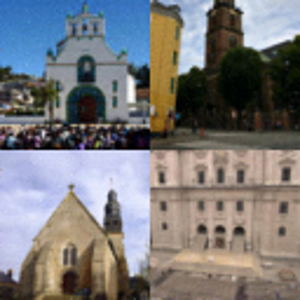

In [56]:
visualize(4)

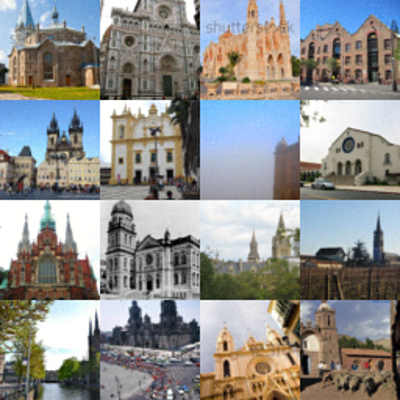

In [61]:
visualize(16, 4, (400, 400))

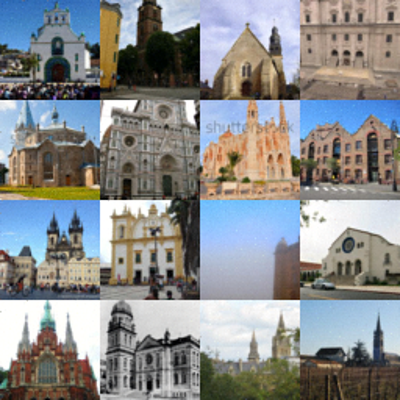

In [62]:
visualize(16, 0, (400, 400))

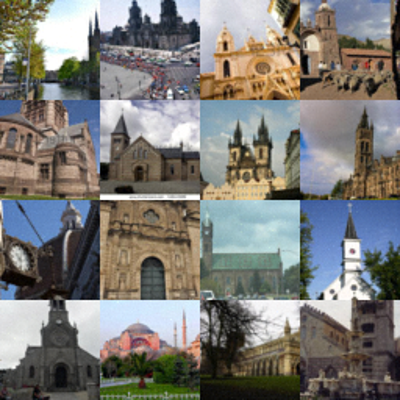

In [63]:
visualize(16, 16, (400, 400))

# NVAE

In [ ]:
!git clone https://github.com/NVlabs/NVAE.git

In [ ]:
%cd NVAE/NVAE

In [ ]:
!python3 train.py --dataset mnist --epochs 3 --root /content/NVAE/NVAE  --data /content/NVAE/NVAE --save /eval- --batch_size 200

In [ ]:
# Import libraries
import argparse
import torch
import torch.nn as nn
import numpy as np
import os

import torch.distributed as dist
from torch.multiprocessing import Process
from torch.cuda.amp import autocast, GradScaler

from model import AutoEncoder
from thirdparty.adamax import Adamax
import utils
import datasets

from fid.fid_score import compute_statistics_of_generator, load_statistics, calculate_frechet_distance
from fid.inception import InceptionV3

import matplotlib.pyplot as plt

In [ ]:
# Get args
PATH = 'eval-/eval-/checkpoint.pt'
checkpoint = torch.load(PATH)
args = checkpoint['args']

In [ ]:
# Create Model
writer = utils.Writer(args.global_rank, args.save)
arch_instance = utils.get_arch_cells(args.arch_instance)
model = AutoEncoder(args, writer, arch_instance)
model = model.cuda()

len log norm: 128
len bn: 92


In [ ]:
# Load Model
model.load_state_dict(checkpoint['state_dict'])

# Initialize
os.environ['MASTER_ADDR'] = args.master_address
os.environ['MASTER_PORT'] = '6020'
torch.cuda.set_device(args.local_rank)
dist.init_process_group(backend='nccl', init_method='env://', rank=0, world_size=args.num_process_per_node)

In [ ]:
# logits = model.sample(4, 1)
# len(logits)
logits = checkpoint['logits']
logits.size()

torch.Size([200, 1, 32, 32])

In [ ]:
losses_nvae = checkpoint['losses']

In [ ]:
# Get args
PATH = '/content/NVAE/eval-/NRAE_checkpoint.pt'
checkpoint_nrae = torch.load(PATH)

In [ ]:
losses_nrae = checkpoint_nrae['losses']

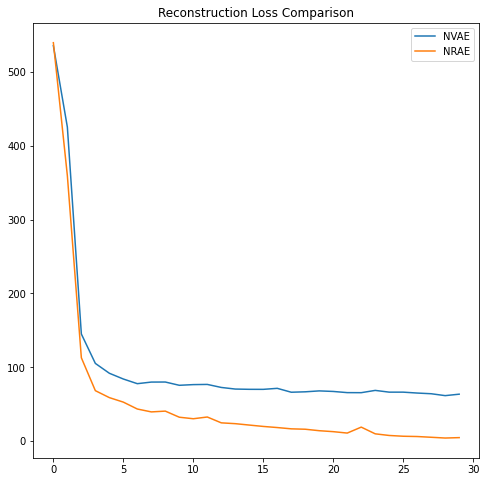

In [ ]:
plt.plot(losses_nvae, label='NVAE')
plt.plot(losses_nrae, label='NRAE')
plt.title('Reconstruction Loss Comparison')
plt.legend();

In [ ]:
logits_nrae = checkpoint_nrae['logits']
logits_nrae.size()

torch.Size([200, 1, 32, 32])

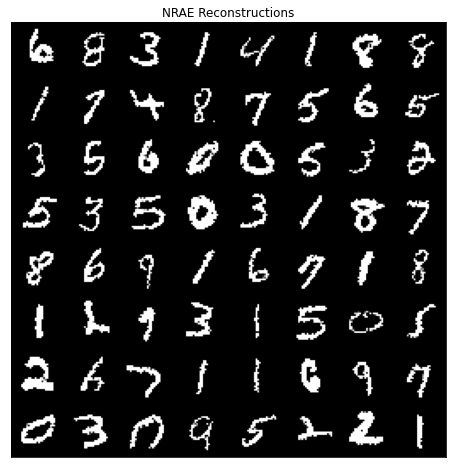

In [ ]:
plt.rcParams['figure.figsize'] = (8, 8)
output = model.decoder_output(logits_nrae[:64])
output_img = output.mean if isinstance(output, torch.distributions.bernoulli.Bernoulli) else output.sample(t)
output_tiled = utils.tile_image(output_img, 8)
plt.imshow(output_tiled[0].double().cpu().detach().numpy(), cmap='gray')
plt.title('NRAE Reconstructions')
plt.gca().axes.get_xaxis().set_visible(False)
plt.gca().axes.get_yaxis().set_visible(False)

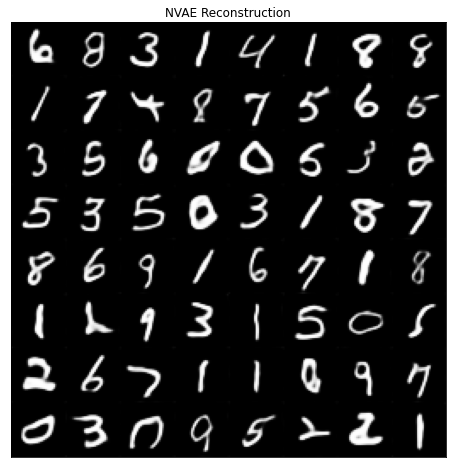

In [ ]:
plt.rcParams['figure.figsize'] = (8, 8)
output = model.decoder_output(logits[:64])
output_img = output.mean if isinstance(output, torch.distributions.bernoulli.Bernoulli) else output.sample(t)
output_tiled = utils.tile_image(output_img, 8)
plt.imshow(output_tiled[0].double().cpu().detach().numpy(), cmap='gray')
plt.title('NVAE Reconstruction')
plt.gca().axes.get_xaxis().set_visible(False)
plt.gca().axes.get_yaxis().set_visible(False)

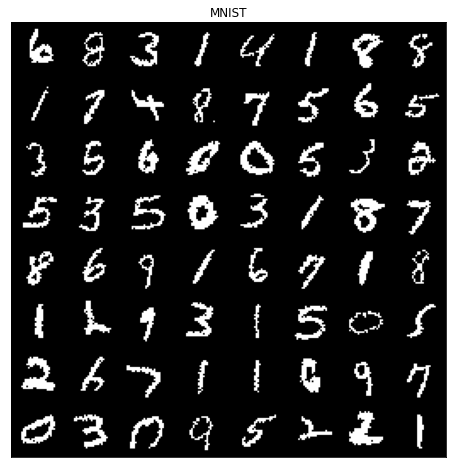

In [ ]:
mnist = checkpoint['dset']
plt.rcParams['figure.figsize'] = (8, 8)
output = model.decoder_output(mnist[:64])
output_img = output.mean if isinstance(output, torch.distributions.bernoulli.Bernoulli) else output.sample(t)
output_tiled = utils.tile_image(output_img, 8)
plt.imshow(output_tiled[0].double().cpu().detach().numpy(), cmap='gray')
plt.title('MNIST')
plt.gca().axes.get_xaxis().set_visible(False)
plt.gca().axes.get_yaxis().set_visible(False)

In [ ]:
mnist.mean()

tensor(0.1013, device='cuda:0')

In [ ]:
logits.mean()

tensor(-7.4258, device='cuda:0', dtype=torch.float16, grad_fn=<MeanBackward0>)

In [ ]:
logits_nrae.mean()

tensor(-23.5000, device='cuda:0', dtype=torch.float16, grad_fn=<MeanBackward0>)

In [ ]:
from torchvision.datasets import MNIST
from torchvision import transforms

In [ ]:
torch.manual_seed(args.seed)
np.random.seed(args.seed)
torch.cuda.manual_seed(args.seed)
torch.cuda.manual_seed_all(args.seed)

class Binarize(object):
    """ This class introduces a binarization transformation
    """
    def __call__(self, pic):
        return torch.Tensor(pic.size()).bernoulli_(pic)

    def __repr__(self):
        return self.__class__.__name__ + '()'

train_transform =transforms.Compose([
                  transforms.Pad(padding=2),
                  transforms.ToTensor(),
                  Binarize(),
              ])
train_data = MNIST(root='/content/NVAE/', download=False, train=True, transform = train_transform)

In [ ]:
train_sampler = torch.utils.data.distributed.DistributedSampler(train_data)
train_queue = torch.utils.data.DataLoader(
        train_data, batch_size=args.batch_size,
        shuffle=(train_sampler is None),
        sampler=train_sampler, pin_memory=True, num_workers=8, drop_last=True)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [ ]:
data = next(iter(train_queue))[-]
data.size()

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


torch.Size([200])

In [ ]:
plt.rcParams['figure.figsize'] = (8, 8)
output = model.decoder_output(data[:64])
output_img = output.mean if isinstance(output, torch.distributions.bernoulli.Bernoulli) else output.sample(t)
output_tiled = utils.tile_image(output_img, 8)
plt.imshow(output_tiled[0].double().cpu().detach().numpy(), cmap='gray')
plt.title('MNIST Reconstruction')
plt.gca().axes.get_xaxis().set_visible(False)
plt.gca().axes.get_yaxis().set_visible(False)

IndexError: ignored

In [ ]:
args.seed

1

In [ ]:
checkpoint.keys()

dict_keys(['epoch', 'state_dict', 'optimizer', 'global_step', 'args', 'arch_instance', 'scheduler', 'logits', 'losses', 'grad_scalar'])